In [1]:
%matplotlib inline

import pickle

from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [4]:
def dense_discriminator(x, is_training, num_classes=10, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x, 512, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, 256, activation=tf.nn.leaky_relu)
        features = tf.layers.dense(x, 128, activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(features, num_classes + 1)
        output = tf.nn.softmax(logits)
        return output, logits, features

In [5]:
def dense_generator(x, is_training, output_shape=(28, 28, 1), reuse=False):
    with tf.variable_scope('generator', reuse=reuse) as scope:
        x = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 512, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, np.prod(output_shape), activation=tf.nn.tanh)
        x = tf.reshape(x, (-1,) + output_shape)
        
        return x

In [6]:
def build_dense_model(x_real, z, is_training, num_classes=10, output_shape=(28, 28, 1)):
    d_real_prob, d_real_logits, d_real_features = dense_discriminator(
        x_real, is_training, num_classes=num_classes, reuse=False,
    )
    x_fake = dense_generator(z, is_training, output_shape=output_shape)
    d_fake_prob, d_fake_logits, d_fake_features = dense_discriminator(
        x_fake, is_training, num_classes=num_classes, reuse=True,
    )
    return d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake

In [7]:
def wasserstein_loss_accuracy(x_real, x_fake, d_real_prob, d_real_logits,
                              d_fake_prob, d_fake_logits, extended_label, labeled_mask):
    epsilon = 1e-8
    
    ### Supervised loss for discriminator
    d_ce = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_real_logits,
                                                      labels=extended_label)
    d_loss_supervised = tf.reduce_sum(labeled_mask * d_ce) / (tf.reduce_sum(labeled_mask) + epsilon)
    
    ### WGAN loss
    y_real = d_real_logits[:, -1]
    y_fake = d_fake_logits[:, -1]
    d_loss_unsupervised = tf.reduce_mean(y_fake) - tf.reduce_mean(y_real)
    
    d_loss = d_loss_supervised + d_loss_unsupervised
    
    g_loss = -tf.reduce_mean(y_fake)
    
    ### Accuracy
    correct_prediction = tf.equal(tf.argmax(d_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return d_loss_supervised, d_loss_unsupervised, d_loss, g_loss, accuracy

In [8]:
def optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate):
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in all_vars if var.name.startswith('generator')]

        d_optimizer = tf.train.RMSPropOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.RMSPropOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        return d_optimizer, g_optimizer

In [9]:
def extend_labels(labels):
    # add extra label for fake data
    extended_label = tf.concat([labels, tf.zeros([tf.shape(labels)[0], 1])], axis=1)

    return extended_label

In [10]:
def moving_average(x, n=10):
    ret = np.cumsum(x)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [17]:
def clip_weights(clip_min, clip_max):
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    
    clip_ops = []
    for var in d_vars:
        op = tf.assign(var, tf.clip_by_value(var, clip_min, clip_max))
        clip_ops.append(op)
    
    return tf.group(*clip_ops)

In [19]:
def execute(x_train, y_train, x_test, y_test,
            epochs=50000, batch_size=32, test_steps=500, num_labeled_examples=None, 
            periodic_labeled_batch=False, periodic_labeled_batch_frequency=10,
            x_height=28, x_width=28, num_channels=1, latent_size=100):
    tf.reset_default_graph()
    
    num_classes = np.unique(y_train).shape[0]
    y_test = to_categorical(y_test, num_classes=num_classes)
    
    x = tf.placeholder(tf.float32, name='x', shape=(None, x_height, x_width, num_channels))
    label = tf.placeholder(tf.float32, name='label', shape=(None, num_classes))
    labeled_mask = tf.placeholder(tf.float32, name='labeled_mask', shape=(None,))
    z = tf.placeholder(tf.float32, name='z', shape=(None, latent_size))
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    g_learning_rate = tf.placeholder(tf.float32, name='g_learning_rate')
    d_learning_rate = tf.placeholder(tf.float32, name='d_learning_rate')
    
    model = build_dense_model(x, z, is_training)
    extended_label = extend_labels(label)
    d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake = model
    loss_acc = wasserstein_loss_accuracy(x, x_fake, d_real_prob, d_real_logits,
                                         d_fake_prob, d_fake_logits, extended_label, labeled_mask)
    _, _, d_loss, g_loss, accuracy = loss_acc
    d_optimizer, g_optimizer = optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate)
    disc_clip_ops = clip_weights(-0.01, 0.01)
    
    if num_labeled_examples is None:
        global_mask = np.ones(x_train.shape[0])
        periodic_labeled_batch = False
    else:
        global_mask = np.zeros(x_train.shape[0])
        for cls in np.unique(y_train):
            idx = y_train == cls
            idx = np.random.choice(np.flatnonzero(idx), num_labeled_examples // num_classes, replace=False)
            global_mask[idx] = 1.0
        
    
    train_d_losses, train_g_losses, train_accuracies = [], [], []
    test_d_losses, test_g_losses, test_accuracies = [], [], []
    
    def test_gan(epoch):
        test_size = x_test.shape[0]
        z_test = np.random.normal(0, 1, (test_size, latent_size))
        test_mask = np.ones(test_size)
        test_dictionary = {
            x: x_test,
            z: z_test,
            label: y_test,
            labeled_mask: test_mask,
            is_training: False
        }

        test_d_loss = d_loss.eval(feed_dict=test_dictionary)
        test_g_loss = g_loss.eval(feed_dict=test_dictionary)
        test_accuracy = accuracy.eval(feed_dict=test_dictionary)

        test_d_losses.append(test_d_loss)
        test_g_losses.append(test_g_loss)
        test_accuracies.append(test_accuracy)

        print(epoch, test_d_loss, test_g_loss, test_accuracy)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for _ in range(5): # 5 = number of iterations for critic training (based off paper).
                if periodic_labeled_batch and epoch % periodic_labeled_batch_frequency == 0:
                    idx = np.flatnonzero(global_mask)
                    x_batch = x_train[idx]
                    y_batch = y_train[idx]
                    mask = global_mask[idx]
                else:
                    idx = np.random.randint(0, x_train.shape[0], batch_size)
                    x_batch = x_train[idx]
                    y_batch = y_train[idx]
                    mask = global_mask[idx]
                y_batch = to_categorical(y_batch, num_classes=num_classes)
                z_batch = np.random.normal(0, 1, (batch_size, latent_size))
                train_dictionary = {
                    x: x_batch,
                    z: z_batch,
                    label: y_batch,
                    labeled_mask: mask,
                    #g_learning_rate: 1e-5,
                    d_learning_rate: 1e-5,
                    is_training: True
                }
                d_optimizer.run(feed_dict=train_dictionary)
                disc_clip_ops.run(feed_dict=train_dictionary)
            
            z_batch = np.random.normal(0, 1, (batch_size, latent_size))
            train_dictionary = { # use last values from critic
                x: x_batch,
                z: z_batch,
                label: y_batch,
                labeled_mask: mask,
                g_learning_rate: 1e-5,
                d_learning_rate: 1e-5,
                is_training: True
            }
            g_optimizer.run(feed_dict=train_dictionary)

            train_d_loss = d_loss.eval(feed_dict=train_dictionary)
            train_g_loss = g_loss.eval(feed_dict=train_dictionary)
            train_accuracy = accuracy.eval(feed_dict=train_dictionary)
            
            train_d_losses.append(train_d_loss)
            train_g_losses.append(train_g_loss)
            train_accuracies.append(train_accuracy)
            
            if epoch % test_steps == 0:
                test_gan(epoch)
        test_gan(epochs)
    
    return train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies

In [13]:
def run_test(output_file, num_labeled_examples=None,
             periodic_labeled_batch=False, periodic_labeled_batch_frequency=10):
    results = execute(x_train, y_train, x_test, y_test)
    train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies = results
    with open(output_file, 'wb') as f:
        pickle.dump({
            'train_d_losses': train_d_losses,
            'train_g_losses': train_g_losses,
            'train_accuracies': train_accuracies,
            'test_d_losses': test_d_losses,
            'test_g_losses': test_g_losses,
            'test_accuracies': test_accuracies
        }, f)
    return results

In [14]:
def plot_losses(results):
    train_d_losses, train_g_losses, _, test_d_losses, test_g_losses, _ = results
    
    average_train_d_losses = moving_average(train_d_losses, 10)
    average_train_g_losses = moving_average(train_g_losses, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_d_losses)), average_train_d_losses, label='discriminator training loss')
    plt.plot(np.arange(len(average_train_g_losses)), average_train_g_losses, label='generator training loss')
    plt.plot(np.arange(len(test_d_losses)) * 500, test_d_losses, label='discriminator test loss')
    plt.plot(np.arange(len(test_g_losses)) * 500, test_g_losses, label='generator test loss')
    plt.legend()

In [15]:
def plot_accuracies(results):
    _, _, train_accuracies, _, _, test_accuracies = results
    
    average_train_accuracies = moving_average(train_accuracies, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_accuracies)), average_train_accuracies, label='training accuracy')
    plt.plot(np.arange(len(test_accuracies)) * 500, test_accuracies, label='test accuracy')
    plt.legend()

In [20]:
results = run_test('wgan-all.pkl')

0 2.3981652 1.028585e-05 0.1411
500 -13.400629 -0.01426044 0.1135
1000 -16.034145 -0.27953336 0.1021
1500 -15.760763 -0.5696053 0.101
2000 -15.390579 -0.94228107 0.1135
2500 -14.823626 -1.5094256 0.1032
3000 -14.082916 -2.2380543 0.1135
3500 -12.965334 -3.3178008 0.1135
4000 -11.630889 -4.550264 0.1071
4500 -9.991213 -5.9679914 0.1028
5000 -8.079922 -7.3900313 0.1135
5500 -5.9775896 -8.692629 0.0981
6000 -3.8380382 -9.989878 0.0982
6500 -1.9705746 -11.112859 0.098
7000 -0.653615 -11.5852375 0.101
7500 0.43613124 -11.77074 0.1135
8000 1.2212486 -11.237636 0.1026
8500 1.6483717 -10.487627 0.1135
9000 1.9990041 -9.844252 0.1135
9500 2.1496305 -9.463496 0.1135
10000 2.2198353 -7.895202 0.098
10500 2.2750485 -6.3235726 0.1135
11000 2.2890425 -5.763524 0.1135
11500 2.3023386 -1.6832813 0.1135
12000 2.3020096 -1.4113195 0.1135
12500 2.1899989 0.0070998487 0.1872
13000 1.5881202 -0.95997053 0.2122
13500 1.9925466 -0.5683326 0.1911
14000 1.715903 1.0018536 0.1844
14500 1.9331903 0.69723094 0.27

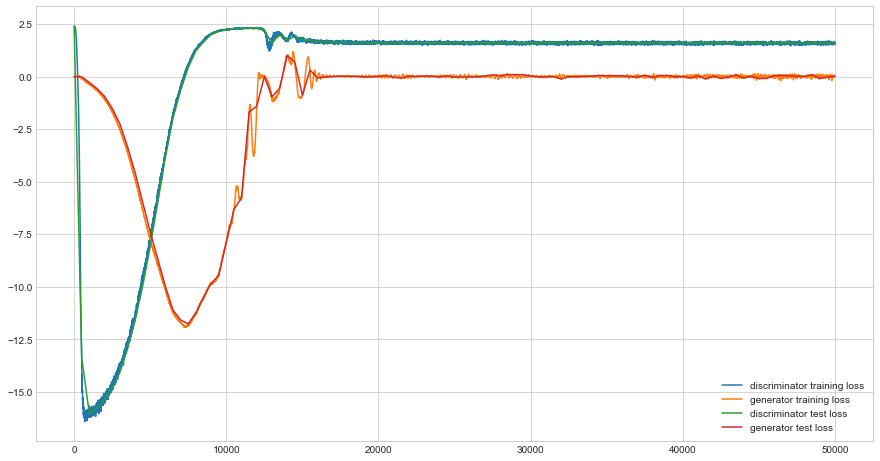

In [21]:
plot_losses(results)

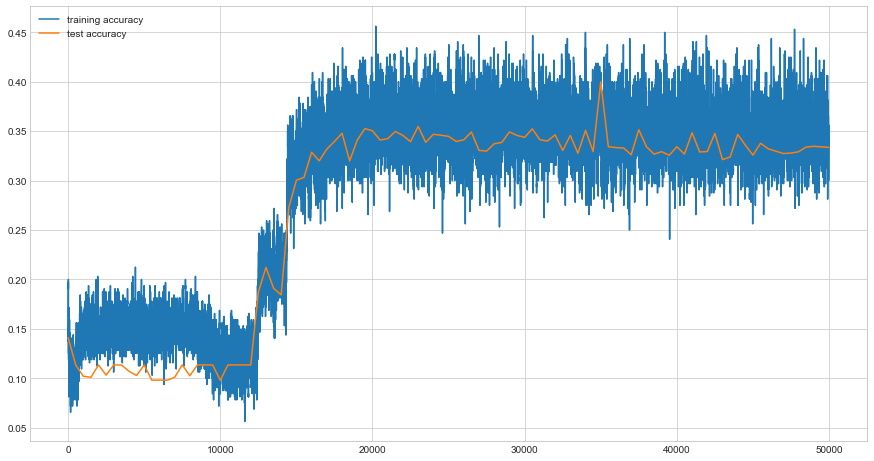

In [22]:
plot_accuracies(results)